In [1]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, \
    Flatten, Lambda, LSTM, RepeatVector, TimeDistributed, Reshape, \
    Conv2D, MaxPooling2D, BatchNormalization, ConvLSTM2D, Bidirectional
from keras.callbacks import ModelCheckpoint

/usr/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = h5py.File("data_sample.hdf5", "r")
images = data["images"][:]
labels = data["labels"][:]

def scale_images(images):
    t_images = np.transpose(images, (0,3,1,2))
    rt_images = t_images.reshape(72000*48, 21, 21)
    max_per_img = np.max(rt_images.reshape(-1, 21*21), axis=1, keepdims=1)
    scaled_images = rt_images.reshape(-1, 21*21) / max_per_img
    scaled_images = scaled_images.reshape(-1, 21, 21).reshape(-1, 48, 21, 21)
    return scaled_images

def txt2digit(labels):
    dic = {'Asteroids':0, 'Constant':1, 'EmptyLigh':2, 'M33Cephei':3, 'RRLyrae':4, 'Supernova':5}
    labels_digit = np.array([dic[i] for i in labels])
    return labels_digit


def build_dataset(images, labels, seq2seq=False):
    
    train_indices = np.random.choice(np.arange(images.shape[0]), int( 0.7 * images.shape[0]))
    val_indices = list(set(np.arange(images.shape[0])) - set(train_indices))
    
    x = images
    x = np.expand_dims(x, len(x.shape))
    y = to_categorical(txt2digit(labels))
    
    if seq2seq:
        y = np.repeat(y, 48).reshape(-1, 48, 6)
    
    return x, y

x, y = build_dataset(scale_images(images), labels)
x = x.reshape(x.shape[:-1]).transpose([0,2,3,1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=209, stratify=y)

In [3]:
def init_cnn():
    model = Sequential()
    
    model.add(Conv2D(48, (4,4), input_shape=(21,21,48), padding='same', activation='relu', kernel_initializer='uniform'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(MaxPooling2D((3,3), strides=(1,1)))
    
    model.add(Conv2D(24, (3,3), padding='same', activation='relu', kernel_initializer='uniform'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(MaxPooling2D((3,3), strides=(1,1)))

    model.add(Conv2D(12, (3,3), padding='same', activation='relu', kernel_initializer='uniform'))
    model.add(MaxPooling2D((3,3), strides=(1,1)))
    
    model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(6, activation='softmax'))

    return model

In [12]:
model = init_cnn()
print(model.summary())
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 21, 21, 48)        36912     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 19, 48)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 24)        10392     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 24)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 12)        2604      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2700)              0         
__________

In [13]:
checkpointer = ModelCheckpoint(filepath='saved_models/cnn.hdf5', verbose=1, save_best_only=True)
history = model.fit(x_train, y_train,
                    batch_size=80,
                    epochs=200,
                    validation_data=[x_test,y_test],
                    callbacks=[checkpointer],
                    shuffle=True)

Train on 57600 samples, validate on 14400 samples
Epoch 1/200
57600/57600 [==============================] - 15s 252us/step - loss: 1.3449 - acc: 0.3963 - val_loss: 1.1446 - val_acc: 0.4044

Epoch 00001: val_loss improved from inf to 1.14457, saving model to saved_models/cnn.hdf5
Epoch 2/200
57600/57600 [==============================] - 14s 245us/step - loss: 1.0513 - acc: 0.4821 - val_loss: 1.1330 - val_acc: 0.4614

Epoch 00002: val_loss improved from 1.14457 to 1.13301, saving model to saved_models/cnn.hdf5
Epoch 3/200
57600/57600 [==============================] - 14s 244us/step - loss: 0.9958 - acc: 0.4958 - val_loss: 0.9972 - val_acc: 0.5181

Epoch 00003: val_loss improved from 1.13301 to 0.99716, saving model to saved_models/cnn.hdf5
Epoch 4/200
57600/57600 [==============================] - 14s 246us/step - loss: 0.9687 - acc: 0.5063 - val_loss: 0.9290 - val_acc: 0.5125

Epoch 00004: val_loss improved from 0.99716 to 0.92896, saving model to saved_models/cnn.hdf5
Epoch 5/200
57

57600/57600 [==============================] - 14s 244us/step - loss: 0.6401 - acc: 0.7023 - val_loss: 0.6277 - val_acc: 0.7067

Epoch 00041: val_loss did not improve
Epoch 42/200
57600/57600 [==============================] - 14s 244us/step - loss: 0.6291 - acc: 0.7055 - val_loss: 0.6507 - val_acc: 0.6960

Epoch 00042: val_loss did not improve
Epoch 43/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.6270 - acc: 0.7060 - val_loss: 0.6166 - val_acc: 0.7127

Epoch 00043: val_loss improved from 0.62119 to 0.61664, saving model to saved_models/cnn.hdf5
Epoch 44/200
57600/57600 [==============================] - 14s 244us/step - loss: 0.6288 - acc: 0.7065 - val_loss: 0.6369 - val_acc: 0.7009

Epoch 00044: val_loss did not improve
Epoch 45/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.6179 - acc: 0.7108 - val_loss: 0.6039 - val_acc: 0.7167

Epoch 00045: val_loss improved from 0.61664 to 0.60395, saving model to saved_models/cnn.hdf5
E


Epoch 00081: val_loss did not improve
Epoch 82/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.5106 - acc: 0.7617 - val_loss: 0.5100 - val_acc: 0.7612

Epoch 00082: val_loss did not improve
Epoch 83/200
57600/57600 [==============================] - 14s 243us/step - loss: 0.5055 - acc: 0.7644 - val_loss: 0.4915 - val_acc: 0.7746

Epoch 00083: val_loss improved from 0.50485 to 0.49154, saving model to saved_models/cnn.hdf5
Epoch 84/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.5025 - acc: 0.7668 - val_loss: 0.5269 - val_acc: 0.7558

Epoch 00084: val_loss did not improve
Epoch 85/200
57600/57600 [==============================] - 14s 243us/step - loss: 0.5389 - acc: 0.7522 - val_loss: 0.4998 - val_acc: 0.7702

Epoch 00085: val_loss did not improve
Epoch 86/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.5014 - acc: 0.7654 - val_loss: 0.5040 - val_acc: 0.7635

Epoch 00086: val_loss did not improve
Epoch

57600/57600 [==============================] - 14s 244us/step - loss: 0.4554 - acc: 0.7891 - val_loss: 0.4672 - val_acc: 0.7866

Epoch 00125: val_loss did not improve
Epoch 126/200
57600/57600 [==============================] - 14s 244us/step - loss: 0.4585 - acc: 0.7866 - val_loss: 0.4633 - val_acc: 0.7870

Epoch 00126: val_loss did not improve
Epoch 127/200
57600/57600 [==============================] - 14s 244us/step - loss: 0.4687 - acc: 0.7825 - val_loss: 0.4547 - val_acc: 0.7905

Epoch 00127: val_loss improved from 0.46320 to 0.45473, saving model to saved_models/cnn.hdf5
Epoch 128/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.4483 - acc: 0.7922 - val_loss: 0.4627 - val_acc: 0.7870

Epoch 00128: val_loss did not improve
Epoch 129/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.4498 - acc: 0.7915 - val_loss: 0.4920 - val_acc: 0.7781

Epoch 00129: val_loss did not improve
Epoch 130/200
57600/57600 [==========================

57600/57600 [==============================] - 14s 245us/step - loss: 0.4148 - acc: 0.8065 - val_loss: 0.4329 - val_acc: 0.8069

Epoch 00167: val_loss did not improve
Epoch 168/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.4062 - acc: 0.8098 - val_loss: 0.4188 - val_acc: 0.8104

Epoch 00168: val_loss did not improve
Epoch 169/200
57600/57600 [==============================] - 14s 246us/step - loss: 0.4043 - acc: 0.8098 - val_loss: 0.4552 - val_acc: 0.8008

Epoch 00169: val_loss did not improve
Epoch 170/200
57600/57600 [==============================] - 14s 245us/step - loss: 0.4053 - acc: 0.8107 - val_loss: 0.4224 - val_acc: 0.8101

Epoch 00170: val_loss did not improve
Epoch 171/200
57600/57600 [==============================] - 14s 246us/step - loss: 0.4058 - acc: 0.8108 - val_loss: 0.4274 - val_acc: 0.8085

Epoch 00171: val_loss did not improve
Epoch 172/200
57600/57600 [==============================] - 14s 246us/step - loss: 0.4071 - acc: 0.8100 - va

In [14]:
import json
with open('cnn_history.json', 'w') as outfile:  
    json.dump(history.history, outfile)

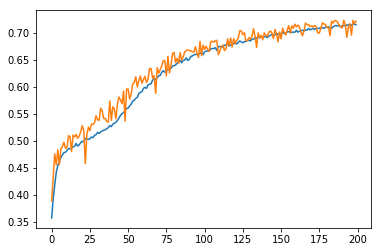

In [11]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])